# DPA Contest v4

## Load traces

In [1]:
import pprint
import glob

# define root directory of all traces (*.bz2)
bz2_trace_directory = "../dpacv4_data/"
# get file names of all traces
bz2_files = [f for f in glob.glob(bz2_trace_directory + "**/*.bz2", recursive=True)]
bz2_files = sorted(bz2_files)
pprint.pprint("number of trace files = %d" % len(bz2_files))

'number of trace files = 5000'


In [2]:
import bz2

DESCRIPTOR_NAME = "Descriptor Name"
TEMPLATE_NAME = "Template Name"
COMM_TYPE = "Comm Type"
COMM_ORDER = "Comm Order"
WAVE_DESCRIPTOR = "Wave Descriptor"
USER_TEXT = "User Text"
RES_DESC1 = "Res Desc1"
TRIGTIME_ARRAY = "TrigTime Array"
RIS_TIME_ARRAY = "Ris Time Array"
RES_ARRAY_1 = "Res Array 1"
WAVE_ARRAY_1 = "Wave Array 1"
WAVE_ARRAY_2 = "Wave Array 2"
INSTRUMENT_NAME = "Instrument Name"
WAVE_ARRAY_COUNT = "Wave Array Count"
FIRST_VALID_POINT = "First Valid Point"
LAST_VALID_POINT = "Last Valid Point"
VERTICAL_GAIN = "Vertical gain"
VERTICAL_OFFSET = "Vertical offset"
NOMINAL_BITS = "Nominal Bits"

DPACV4_OFFSET = 11

import struct

def decode_trace(binary_data):
    if 0 == int.from_bytes(binary_data[34:36], byteorder='big'):
        byteorder = '>'
    else:
        byteorder = '<'
       
    header = {
        DESCRIPTOR_NAME : binary_data[0:16].decode('utf8'),
        TEMPLATE_NAME : binary_data[16:32].decode('utf8'),
        COMM_TYPE : struct.unpack('%sH' % byteorder, binary_data[32:34])[0],
        COMM_ORDER : struct.unpack('%sH' % byteorder, binary_data[34:36])[0],
        WAVE_DESCRIPTOR : struct.unpack('%sL' % byteorder, binary_data[36:40])[0],
        USER_TEXT : struct.unpack('%sL' % byteorder, binary_data[40:44])[0],
        RES_DESC1 : struct.unpack('%sL' % byteorder, binary_data[44:48])[0],
        TRIGTIME_ARRAY : struct.unpack('%sL' % byteorder, binary_data[48:52])[0],
        RIS_TIME_ARRAY : struct.unpack('%sL' % byteorder, binary_data[52:56])[0],
        RES_ARRAY_1 : struct.unpack('%sL' % byteorder, binary_data[56:60])[0],
        WAVE_ARRAY_1 : struct.unpack('%sL' % byteorder, binary_data[60:64])[0],
        WAVE_ARRAY_2 : struct.unpack('%sL' % byteorder, binary_data[64:68])[0],
        INSTRUMENT_NAME : binary_data[76:116].decode('utf8'),
        WAVE_ARRAY_COUNT : struct.unpack('%sL' % byteorder, binary_data[116:120])[0],
        FIRST_VALID_POINT : struct.unpack('%sL' % byteorder, binary_data[124:128])[0],
        LAST_VALID_POINT : struct.unpack('%sL' % byteorder, binary_data[128:132])[0],
        VERTICAL_GAIN : struct.unpack('%sf' % byteorder, binary_data[156:160])[0],
        VERTICAL_OFFSET : struct.unpack('%sf' % byteorder, binary_data[160:164])[0],
        NOMINAL_BITS : struct.unpack('%sH' % byteorder, binary_data[172:174])[0],
    }
    
    data = binary_data[header[WAVE_DESCRIPTOR] + 1: ]
    pprint.pprint('unpack data length = %d' % len(data))
    if 0 == header[COMM_TYPE]:
        iter_unpack = struct.iter_unpack('%sb' % byteorder, data)
    else:
        iter_unpack = struct.iter_unpack('%sh' % byteorder, data)
    trace = [x[0] for x in iter_unpack]
        
    assert(len(trace) == header[WAVE_ARRAY_COUNT])
    return header, list(trace)


def load_trace_file(filename):    
    pprint.pprint('bz2_files = %s' % filename)
    with bz2.BZ2File(filename=filename, mode='r') as fd:
        raw_data = fd.read()
    pprint.pprint(len(raw_data))
    trace_header, trace_data = decode_trace(raw_data[DPACV4_OFFSET:])
    return trace_header, trace_data

In [3]:
# extract one data file
trace_index = 25
trace_header, trace_data = load_trace_file(bz2_files[trace_index])
pprint.pprint(trace_header)
pprint.pprint('data length = %d' % len(trace_data))

'bz2_files = ../dpacv4_data/k00/DPACV42_000025.trc.bz2'
1704760
'unpack data length = 1704402'
{'Comm Order': 1,
 'Comm Type': 0,
 'Descriptor Name': 'WAVEDESC\x00\x00\x00\x00\x00\x00\x00\x00',
 'First Valid Point': 0,
 'Instrument Name': 'LECROYWR6100A\x00\x00\x00EH\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x006\x1b\x1a\x00',
 'Last Valid Point': 1704401,
 'Nominal Bits': 8,
 'Res Array 1': 0,
 'Res Desc1': 0,
 'Ris Time Array': 0,
 'Template Name': 'LECROY_2_3\x00\x00\x00\x00\x00\x00',
 'TrigTime Array': 0,
 'User Text': 0,
 'Vertical gain': 0.0004655862576328218,
 'Vertical offset': -0.004252725746482611,
 'Wave Array 1': 1704402,
 'Wave Array 2': 0,
 'Wave Array Count': 1704402,
 'Wave Descriptor': 346}
'data length = 1704402'


<IPython.core.display.Javascript object>


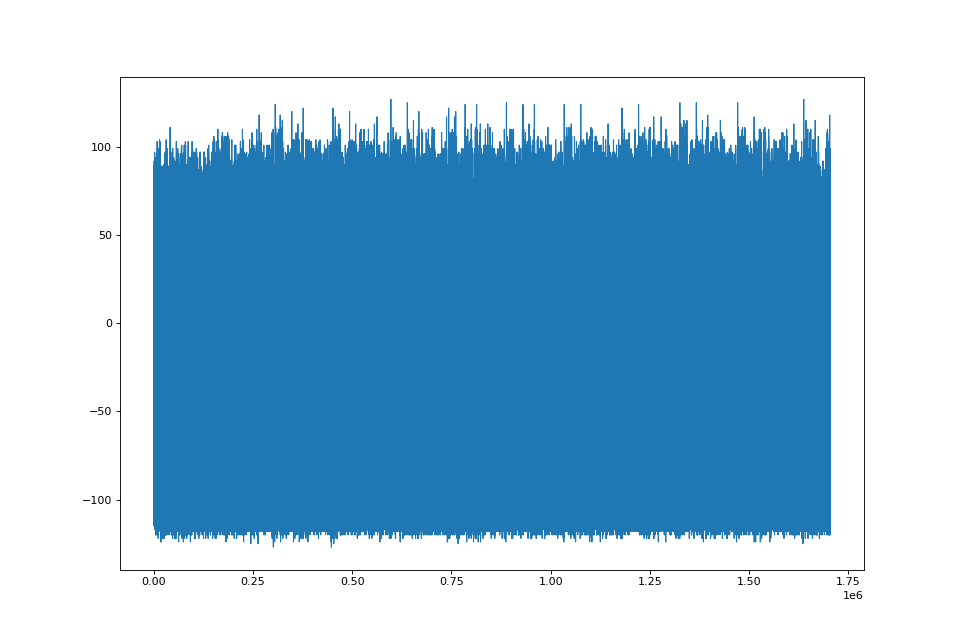

In [4]:
%matplotlib notebook 

from matplotlib import pyplot as plt

draw_trace = trace_data

plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(len(draw_trace)), draw_trace, linewidth=1)
#plt.scatter(range(len(draw_trace)), draw_trace, s=1)
plt.show()